# Tutorial on Diffusion Models.

Diffusion models are a class of generative models that have gained significant attention in recent years for their ability to produce high-quality images, audio, and other types of data. They operate by simulating a diffusion process, gradually transforming data from noise into a structured form through a series of denoising steps.

In [1]:
import torch
import torch.nn as nn

from torch.utils.data  import DataLoader
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torchvision import datasets, transforms, utils


from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Setup the MNIST dataset

As in previous weeks, we will use the MNIST dataset for this tutorial. This dataset contains handwritten digits, comprising 60,000 training images and 10,000 test images. Each image is a 28x28 grayscale image.

In the first part of the tutorial, we will focus on a single digit (for example, 6) to expedite the training of our diffusion model. In the second part, we will include all digits and train a conditional diffusion model.

In [2]:
# where to save the data
data_dir  = 'Data'
bs_train  = 128
bs_test   = 128

# load the data here the transform will include additional scaling (normalised to [-1,1])
transform    = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x*2-1)])
train_dataset = MNIST(root= data_dir, train=True, download=False,transform=transform)
test_dataset  = MNIST(root= data_dir, train=False, download=False,transform=transform)


# select only the digit 6
train_dataset.data  = train_dataset.data[train_dataset.targets==6]
train_dataset.targets = train_dataset.targets[train_dataset.targets==6]
test_dataset.data   = test_dataset.data[test_dataset.targets==6]
test_dataset.targets  = test_dataset.targets[test_dataset.targets==6]

# --- loaders
test_dataloader  = DataLoader(test_dataset, batch_size=bs_test, shuffle=False, num_workers=0,pin_memory=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs_train, shuffle=True,num_workers=0,pin_memory=False)

### Foward diffusion Process

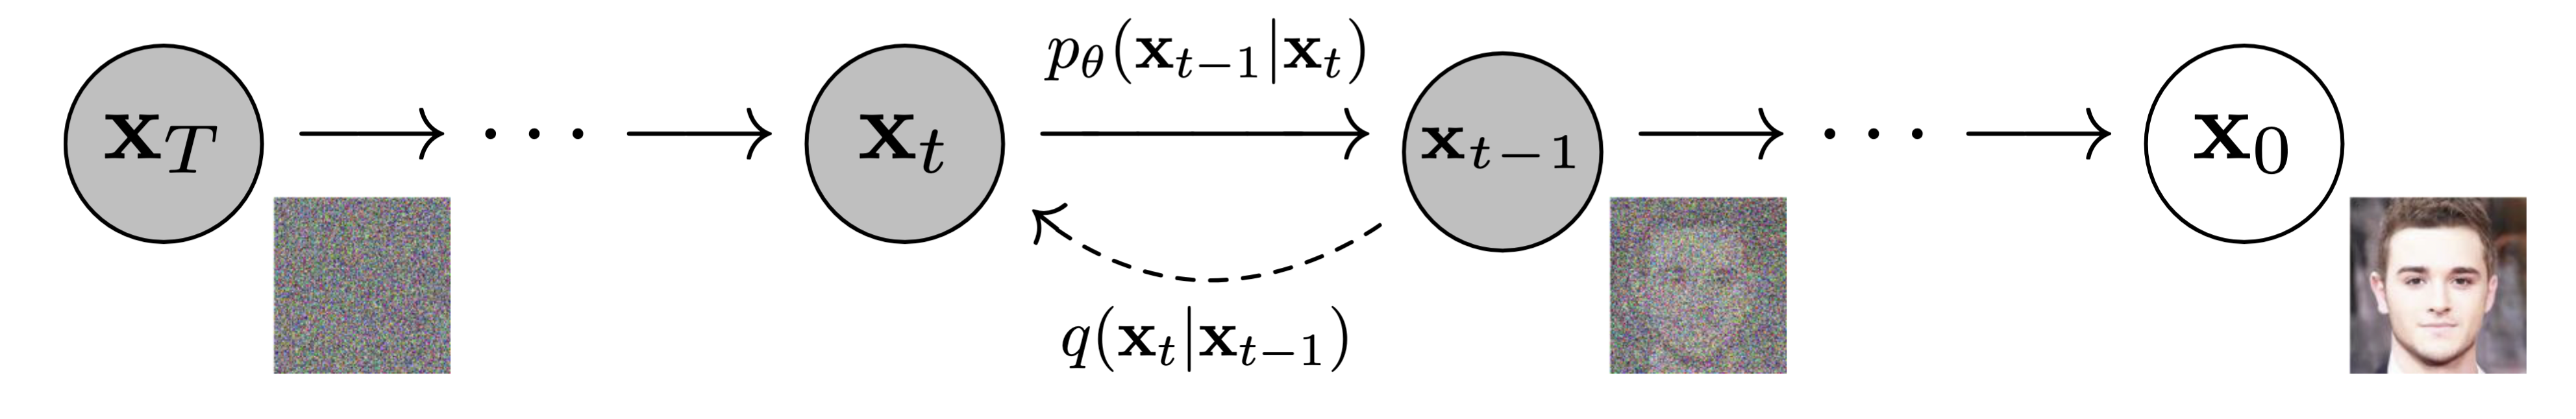

For a given data point $\mathbf{x}_0$, we define a forward process that gradually adds Gaussian noise over a series of $T$ time steps. This forward process, also known as the diffusion process, depends on a variance schedule $\beta_1, \beta_2, \ldots, \beta_T$ and is defined as:


$$q(\mathbf{x}_{1:T} | \mathbf{x}_0) = \prod_{t=1}^T q(\mathbf{x}_t | \mathbf{x}_{t-1}), \quad q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I})$$


This process will gradually introduce noise to the data. After a sufficient number of steps, the data will transform into pure Gaussian noise. Using the provided code, experiment with different values of $\beta$ and varying numbers of steps to observe their effects on the diffusion process.

In [ ]:
N_samples = 1000

x_0 = .7
x = x_0
beta = 0.01
xts_list = []

N_steps = 1000
for t in range(N_steps):
    noise = torch.randn(N_samples)
    x = np.sqrt(1-beta)*x + np.sqrt(beta)*noise
    xts_list.append(x.numpy())

xts_list = np.array(xts_list)
nb_plots = 10
stride = N_steps//nb_plots
xts_list = xts_list[::stride,:]


plt.figure(figsize=(10,6))
for i in range(xts_list.shape[0]):
    sns.kdeplot(xts_list[i,:], label=f'Step {i*stride}')

plt.ylabel('Density')
plt.xlabel('x')
plt.title('Forward Diffusion Process')

x_vals = np.linspace(-4,4,1000)
plt.plot(x_vals, 1/np.sqrt(2*np.pi)*np.exp(-0.5*x_vals**2), 'r--', label='N(0,1)')
plt.legend()
plt.show()


Having the final noisy image $\mathbf{x}_T \sim \mathcal{N}(0, \mathbf{I})$ is crucial, as it will allow the generation of a new image starting from a random matrix.

During training, we will randomly sample a time step $t$, using the additive process we implemented above is **very inefficient**, as we will have to go through all the intermediate steps.

Given the original image $\mathbf{x}_0$ we can directly sample the noisy image at any time step $t$ without having to go through all the intermediate steps, using the reparameterization trick and setting $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$, we have:

$$
\begin{aligned}
q(\mathbf{x}_t | \mathbf{x}_{t-1}) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathbf{I}) \\
\mathbf{x}_{t} &= \sqrt{\alpha_t} \mathbf{x}_{t-1} + \sqrt{1 - \alpha_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, \mathbf{I}) \\
\mathbf{x}_{t} &= \sqrt{\alpha_t \alpha_{t-1}} \mathbf{x}_{t-2} + \sqrt{\alpha_{t}}\sqrt{1 - \alpha_{t-1}} \epsilon +   \sqrt{1 - \alpha_t} \epsilon\\
\mathbf{x}_{t} &= \sqrt{\alpha_t \alpha_{t-1}} \mathbf{x}_{t-2} + \sqrt{(1 - \alpha_{t}\alpha_{t-1})} \epsilon \\
& \cdots \\
\mathbf{x}_{t} &= \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon \quad, \text{where } \bar{\alpha}_t = \prod_{s=1}^t \alpha_s
\end{aligned}
$$


Note that in this equation, $\beta_t$ and $\alpha_t$ are dependent on the time step $t$. For this tutorial, we will make use of the original schedule proposed in the DDPM paper, which is a linear schedule that linearly increases $\beta_t$ from 0.0001 to 0.02 over the course of $=1000$ time steps.

Implement the function `linear_beta_schedule` to create the variance schedule, and the function `q_sample` to sample the noisy image at any time step `t` given the original image `x_0`.



In [ ]:
def extract(a, t, x_shape):
    """
    Extracts coefficients at specified timesteps, then reshapes to [batch_size, 1, 1, 1] for broadcasting purposes 
    (piecewise multiplication with the noise image)
    a: Tensor of shape (num_timesteps) (e.g. alpha_bar)
    t: Tensor of shape (batch_size) with timestep indices
    """    
    batch_size = t.shape[0]
    out = a.gather(-1, t).reshape(batch_size, *((1,) * (len(x_shape) - 1)))
    return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
timesteps = 1000

def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return None

betas = linear_beta_schedule(timesteps).to(device)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0).to(device)
    sqrt_alpha_bar = None
    sqrt_one_minus_alpha_bar = None
    return None

In [ ]:
extract(torch.sqrt(alpha_bars), torch.tensor([0,1,2,3]).to(device), (4,1,28,28))

Test your function using the linear variance schedule provided below.

In [ ]:

img, label = next(iter(train_dataloader))
img = img[:16,:,:,:]
plt.figure(figsize=(6,6))
img_grid = utils.make_grid((img+1)/2, nrow=4)
plt.imshow(img_grid.permute(1,2,0).cpu())
plt.axis('off')
plt.title('Original Images')
plt.show()
img = img.to(device)

timesteps_investigated = [25,50,100,250,500,999]
plt.figure(figsize=(12,8))

for i,t in enumerate(timesteps_investigated):
    t = torch.tensor([t]*img.shape[0]).to(device)
    noised_img = q_sample(img, t)
    noised_img = noised_img.clamp(-1,1)
    plt.subplot(2,3,i+1)
    img_grid = utils.make_grid((noised_img+1)/2, nrow=4)
    plt.imshow(img_grid.permute(1,2,0).cpu())
    plt.axis('off')    
    plt.title(f'Noised Images at step {timesteps_investigated[i]}');
plt.show()




x = q_sample(img, torch.tensor([999]*img.shape[0]).to(device)).view(-1).cpu().numpy()
plt.figure(figsize=(8,5))
sns.kdeplot(x, label=f'Step 999')
plt.ylabel('Density')
plt.xlabel('Pixel value')
x_vals = np.linspace(-4,4,1000)
plt.plot(x_vals, 1/np.sqrt(2*np.pi)*np.exp(-0.5*x_vals**2), 'r--', label='N(0,1)')
plt.legend()
plt.title('Distribution of Noised Pixels at step 999');


## Backward diffusion process


We now have a method to gradually add noise to an image, allowing us to define our backward model, $ p_\theta(x_{t-1} | x_t) $. This model will learn to reverse the diffusion process and generate new images from noise. 

We will use the UNet architecture, which outputs an image of the same size as the input. Unlike previous tutorials, this architecture features skip connections between the downsampling and upsampling layers.

As noted earlier, both $ \beta_t $ and $ \alpha_t $ depend on $ t $, so we need to provide this information to the network. In this tutorial, we will use a simple time MLP to encode the timestep and inject this information at various stages of the embedding and decoding process.


In [7]:
channels = 1 # for MNIST

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(),
        )
    def forward(self, x):
        return self.net(x)

class Unet(nn.Module):
    def __init__(self, ch=32):
        super().__init__()
        # encoder
        self.enc1 = ConvBlock(channels, ch)
        self.enc2 = ConvBlock(ch, ch*2)
        # bottleneck
        self.bot = ConvBlock(ch*2, ch*2)
        # decoder
        self.dec2 = ConvBlock(ch*2 + ch*2, ch)
        self.dec1 = ConvBlock(ch + ch, ch)
        # final
        self.final = nn.Conv2d(ch, channels, 1)

        # timestep embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, ch),
            nn.ReLU(),
            nn.Linear(ch, ch)
        )

        # projections to match channel dims
        self.to_e1 = nn.Conv2d(ch, ch, 1)
        self.to_e2 = nn.Conv2d(ch, ch*2, 1)
        self.to_b  = nn.Conv2d(ch, ch*2, 1)
        self.to_d2 = nn.Conv2d(ch, ch, 1)
        self.to_d1 = nn.Conv2d(ch, ch, 1)

        self.pool = nn.AvgPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, t):        
        t = t.float().unsqueeze(-1) / timesteps
        t_emb = self.time_mlp(t).unsqueeze(-1).unsqueeze(-1)  # (B, ch,1,1)

        e1 = self.enc1(x) + self.to_e1(t_emb)
        e2 = self.enc2(self.pool(e1)) + self.to_e2(t_emb)

        b = self.bot(self.pool(e2)) + self.to_b(t_emb)

        d2 = self.upsample(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2) + self.to_d2(t_emb)

        d1 = self.upsample(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1) + self.to_d1(t_emb)

        return self.final(d1)

In [ ]:
model_test = Unet().to(device)
t_embed = model_test.time_mlp(torch.tensor([[10.],[500.],[999.]]).to(device)/1000)
print(t_embed.shape)
t_embed = t_embed.unsqueeze(-1).unsqueeze(-1)
print(t_embed.shape)
print(model_test.to_e1(t_embed).shape)
print(model_test.to_e2(t_embed).shape)



To optimize training time, we employed a minimal U-Net architecture featuring basic blocks and activation functions. More sophisticated architectures and activation functions, such as the SiLU activation function, group normalization, and attention mechanisms, could enhance the network's performance.

Currently, the time embedding is quite simple; however, more advanced embeddings, like the Transformer's sinusoidal position embeddings, can be utilized.

Lastly, we used a linear variance schedule. By implementing different variance schedules, such as the cosine schedule, it is possible to train diffusion models more quickly and with fewer steps.


## Training the model
Using the Algorithm 1 from the DDPM paper (provided below) and the provided training loop, update the code to train the diffusion model.

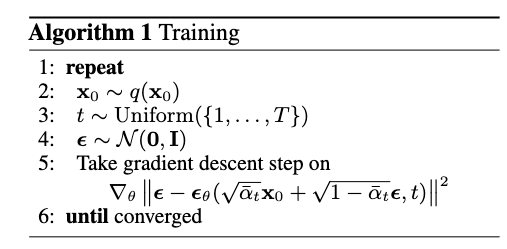

In [ ]:
import time

runtime = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
torch.cuda.manual_seed(0)


image_size = 28
channels = 1
epochs = 400
lr = 2e-4
n_channels_unet = 32

torch.manual_seed(0)


# define model and optimiser
model = Unet(ch=n_channels_unet).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

loss_fn = None
for epoch in range(epochs):
    model.train()
    pbar = tqdm(iterable=train_dataloader, unit="batch",desc=f'training epoch {epoch+1}/{epochs}', colour='GREEN')
    for imgs, _ in pbar:
        imgs = imgs.to(device)

        batch_size = imgs.shape[0]
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        noise = torch.randn_like(imgs)
        x_t = None

        pred_noise = None
        loss = loss_fn(None)

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_postfix(loss=loss.item())
        pbar.update(1)
    pbar.close()


print(f'Training time: {time.time()-runtime:.2f} seconds')


## Sampling from the Diffusion model

Now that you have trained the model, we can implement the reverse diffusion process to generate new images from noise. Using Algorithm 2 from the DDPM paper (provided below), complete the implementation of the function `p_sample_DDPM`, which undoes one step of the diffusion process, and the function `p_sample_loop_DDPM`, which generates a new image starting from pure Gaussian noise.
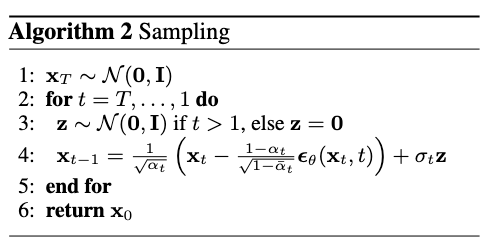

In [ ]:
@torch.no_grad()
def p_sample_DDPM(model, x_t, t_index):
    """
    Single reverse step
    t_index: scalar int (0..T-1) (all elements in batch have same t)
    """
    t = torch.full((x_t.shape[0],), t_index, device=x_t.device, dtype=torch.long)
    beta = extract(betas, t, x_t.shape)
    alpha = extract(alphas, t, x_t.shape)
    alpha_bar = extract(alpha_bars, t, x_t.shape)
    sigma = torch.sqrt(beta)
    
    pred_noise = model(x_t, t)

    if t_index == 0:
        z = 0
    else:
        z = torch.randn_like(x_t)
    
    x_tm1 = None
    
    return x_tm1

@torch.no_grad()
def p_sample_loop_DDPM(model, n_samples=16,seed=1337):
    model.eval()
    torch.manual_seed(seed)
    x = torch.randn(n_samples, channels, image_size, image_size).to(device)  # x_T ~ N(0,I)
    pbar = tqdm(reversed(range(0, timesteps)), desc='Sampling loop', total=timesteps, colour='BLUE')
    for t in pbar:
        x = p_sample_DDPM(model, x, t)
    return x.clamp(-1,1)

In [ ]:

samples = p_sample_loop_DDPM(model, n_samples=32)
samples = (samples + 1.0) / 2.0
grid = utils.make_grid(samples, nrow=8)
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(grid.permute(1,2,0).cpu())
plt.title('Generated Images from DDPM')
plt.show()

# Conditional Diffusion model
This time, we will consider all the digits in the MNIST dataset and train a conditional diffusion model. We need to provide the digit label as an additional input to the model. Since the class input is categorical, we will use an embedding from `torch.nn` to convert the class label into a fixed-size vector.

In [12]:
class_embedding = nn.Embedding(10, 20)

In [13]:
# print(class_embedding(torch.tensor([1])))
# print(class_embedding(torch.tensor([2])))
# print(class_embedding(torch.tensor([1,2])))

Modify the `UNet_cond` class to include a class embedding and inject this information at different stages of the embedding and decoding process.

In [ ]:
class UNet_cond(nn.Module):
    def __init__(self, ch=32, n_classes=10):
        super().__init__()
        # encoder
        self.enc1 = ConvBlock(channels, ch)
        self.enc2 = ConvBlock(ch, ch*2)
        # bottleneck
        self.bot = ConvBlock(ch*2, ch*2)
        # decoder
        self.dec2 = ConvBlock(ch*2 + ch*2, ch)
        self.dec1 = ConvBlock(ch + ch, ch)
        # final
        self.final = nn.Conv2d(ch, channels, 1)

        # timestep embedding
        self.time_mlp = nn.Sequential(
            nn.Linear(1, ch),
            nn.ReLU(),
            nn.Linear(ch, ch)
        )

        # class embedding
        self.class_emb = None

        # projections to match channel dims
        self.to_e1 = nn.Conv2d(ch, ch, 1)
        self.to_e2 = nn.Conv2d(ch, ch*2, 1)
        self.to_b  = nn.Conv2d(ch, ch*2, 1)
        self.to_d2 = nn.Conv2d(ch, ch, 1)
        self.to_d1 = nn.Conv2d(ch, ch, 1)

        self.pool = nn.AvgPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, t, y):        
        t = t.float().unsqueeze(-1) / timesteps
        t_emb = self.time_mlp(t).unsqueeze(-1).unsqueeze(-1)  
        
        y_emb = None

        cond_emb = None

        e1 = self.enc1(x) + self.to_e1(cond_emb)
        e2 = self.enc2(self.pool(e1)) + self.to_e2(cond_emb)

        b = self.bot(self.pool(e2)) + self.to_b(cond_emb)

        d2 = self.upsample(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2) + self.to_d2(cond_emb)

        d1 = self.upsample(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1) + self.to_d1(cond_emb)

        return self.final(d1)

In [ ]:
transform    = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x*2-1)])
train_dataset = MNIST(root= data_dir, train=True, download=False,transform=transform)
test_dataset  = MNIST(root= data_dir, train=False, download=False,transform=transform)

test_dataloader  = DataLoader(test_dataset, batch_size=bs_test, shuffle=False, num_workers=0,pin_memory=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs_train, shuffle=True,num_workers=0,pin_memory=False)

In [ ]:
import time
runtime = time.time()

# hyper parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
torch.cuda.manual_seed(0)
image_size = 28
channels = 1
epochs = 100
lr = 2e-4
n_channels_unet = 32
n_class = 10

torch.manual_seed(0)


# define model and optimiser
model = UNet_cond(ch=n_channels_unet, n_classes=n_class).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()

for epoch in range(epochs):
    model.train()
    pbar = tqdm(iterable=train_dataloader, unit="batch",desc=f'training epoch {epoch+1}/{epochs}', colour='GREEN')
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device) 

        batch_size = imgs.shape[0]
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()
        noise = torch.randn_like(imgs)
        x_t = q_sample(imgs, t, noise=noise)

        pred_noise = model(x_t, t, labels)
        loss = loss_fn(pred_noise, noise) 

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        pbar.set_postfix(loss=loss.item())
        pbar.update(1)
    pbar.close()

print(f'Training time: {time.time()-runtime:.2f} seconds')


## Generate artificial digits
Finally, we can use the trained conditional diffusion model to generate artificial digits.

In [ ]:
@torch.no_grad()
def p_sample_cDDPM(model, x_t, t_index, y):
    """
    Single reverse step
    t_index: scalar int (0..T-1) (all elements in batch have same t)
    """
    t = torch.full((x_t.shape[0],), t_index, device=x_t.device, dtype=torch.long)
    beta = extract(betas, t, x_t.shape)
    alpha = extract(alphas, t, x_t.shape)
    alpha_bar = extract(alpha_bars, t, x_t.shape)
    sigma = torch.sqrt(beta)
    
    pred_noise = model(x_t, t, y)

    if t_index == 0:
        z = 0
    else:
        z = torch.randn_like(x_t)
    
    x_tm1 = 1.0 / alpha.sqrt() * (x_t - beta / ( (1 - alpha_bar).sqrt() ) * pred_noise) + sigma*z
    
    return x_tm1

@torch.no_grad()
def p_sample_loop_cDDPM(model, y, seed=1337):
    model.eval()
    torch.manual_seed(seed)
    n_samples = y.shape[0]
    x = torch.randn(n_samples, channels, image_size, image_size).to(device)  # x_T ~ N(0,I)
    pbar = tqdm(reversed(range(0, timesteps)), desc='Sampling loop', total=timesteps, colour='BLUE')
    for t in pbar:
        x = p_sample_cDDPM(model, x, t , y)
    return x.clamp(-1,1)

In [ ]:

sample_per_class = 16
labels = torch.arange(0,10).unsqueeze(1).repeat(1,sample_per_class).view(-1).to(device)
samples = p_sample_loop_cDDPM(model, labels)
samples = (samples + 1.0) / 2.0
grid = utils.make_grid(samples, nrow=16)
plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(grid.permute(1,2,0).cpu())
plt.title('Generated Images from conditional DDPM')
plt.show()

In [ ]:
# Display real digits
nb_samples = 16
all_found = False
test_sample = {}
while not all_found:
    img, label = next(iter(test_dataloader))
    for i in range(img.shape[0]):
        if len(test_sample) == 0 or label[i].item() not in test_sample:
            test_sample[label[i].item()] = [img[i].detach().cpu()]
        elif len(test_sample[label[i].item()]) < nb_samples:
            test_sample[label[i].item()].append(img[i].detach().cpu())
    
    for k in range(10):
        all_found = True
        if k not in test_sample or len(test_sample[k]) < nb_samples:
            all_found = False
            break

real_samples = []
for k in range(10):
    real_samples += test_sample[k][:nb_samples]
real_samples = torch.stack(real_samples, dim=0)
plt.figure(figsize=(16,8))
real_samples_grid = utils.make_grid((real_samples+1)/2, nrow=16)
plt.imshow(real_samples_grid.permute(1,2,0).cpu())
plt.axis('off')
plt.title('Real Images from MNIST')
plt.show()